<a href="https://colab.research.google.com/github/pe44enka/TravelViz/blob/master/VizProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Travel History Visualization

![](https://cdn.shopify.com/s/files/1/1599/0747/products/Gale_Nation_Haven_t_Been_Everywhere_but_it_s_on_my_list_hand_lettered_cream_world_map_-1_8b628f6c-d85f-4d5c-931b-865895257fc8_1800x1800.png?v=1506376978)


### Objectives

After some years of travelling around the globe I have plenty of stories for my friends abd family from different parts of world. And any story is better with visualizations. Here is my story of travelling visualized with Python.

This is also my final project for Data Viz with Python class at Stanford Continuing Studies.


---

### Goal of the project
Visualize my own travel history by using Viz libraries of Python such as matplotlib, altair, Basemap, folium, seaborn etc.

### Data
Personal trips data collected over years by project's owner.

---

# Load Libraries

In [ ]:
#install basemap
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from IPython.display import HTML
from matplotlib import style
import matplotlib.ticker as ticker
import folium
from matplotlib.font_manager import FontProperties
import matplotlib
import altair as alt

from vega_datasets import data
from urllib.request import Request, urlopen, urlretrieve
import json
from google.colab import files



---



# US Trip



Let's start with **altair** and create US map with marked states that have been visited.
For this we need:
* load data about US trips
* create 2 altair objects:
  * map itself with marked states
  * legend just with states which were visited

**Spoiler:** if you click on one of the state on the legend you can observe the shape of this state on the map.

---



In [ ]:
#load data
state_data = pd.read_csv('https://raw.githubusercontent.com/pe44enka/Travel_Viz/master/data/states.csv')
state_data.tail()

State Abbr    Visit  id
47       Virginia   VA      NaN  51
48     Washington   WA      NaN  53
49  West Virginia   WV      NaN  54
50      Wisconsin   WI      NaN  55
51        Wyoming   WY  Visited  56

In [ ]:
#create geo object which is going to be visualize: base map of the US
states_geo = alt.topo_feature(data.us_10m.url, 'states')

#connect map and legend: choose one state on the legend --> show this state on the map
selection = alt.selection_multi(fields=['State'])

#create states map
states_map = (alt
              .Chart(states_geo)
              .mark_geoshape()
              .properties(height=300, width=450, title = "MY US TRIP MAP")
              .encode(alt.Color('Visit:N',scale=alt.Scale(scheme='greenblue'), legend = None), tooltip=['State:N'])
              .project(type='albersUsa')
              .transform_lookup(lookup = 'id', from_ = alt.LookupData(state_data, 'id', ['State', 'Visit']))
              .transform_filter(selection)
              )

#create legend 
visited_states = state_data[~state_data.Visit.isna()] #df just with states which I have visited
states_legend = (alt
                 .Chart(visited_states)
                 .mark_point()
                 .properties(height=300, width=25)
                 .encode(y=alt.Y('State:N', axis=alt.Axis(orient='left'),
                                 title = "Click to see certain state"),
                                 #tooltip=['State:N']), 
                                 color = alt.condition(selection, 
                                                       alt.Color('Visit:N', scale=alt.Scale(scheme='greenblue'), legend=None),
                                                       alt.value('lightgrey')))
                 .add_selection(selection))

#plot both object together: horizontal concatenation
states_map | states_legend

alt.HConcatChart(...)



---



# World Trip


Now let's zoom out and consider the whole world. For this we need to load data about world trip.

---

In [ ]:
#load data
country_data = pd.read_csv('https://raw.githubusercontent.com/pe44enka/main/master/data/country.csv')
country_data.set_index('Abbr', inplace = True) #set Abbr of country as index
country_data.tail()

Country  Year  Code  Region
Abbr                                 
CHE   Switzerland  2020   756  Europe
TZA      Tanzania  2020   834  Africa
ESP         Spain  2020   724  Europe
ARE           UAE  2020   784    Asia
RUS        Russia  2020   643  Europe

In [ ]:
#save shp etc files, used for basemape
for ext in ['shp', 'shx', 'dbf']:
  urlretrieve('https://github.com/pe44enka/main/raw/master/data/all_country.' + ext, 'all_country.' + ext)

## World Trip Map



Let's start our journey from observing all visited countries by highlighting them on the world map. For this we will use **matplotlib** & **Basemap**.

---



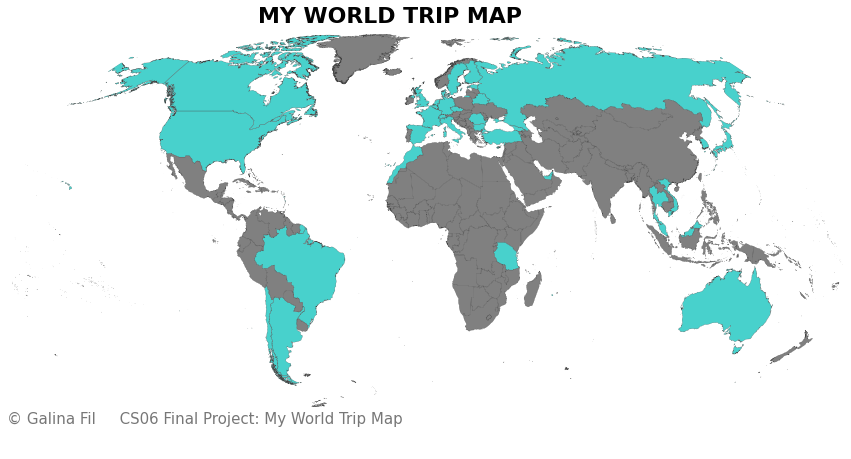

In [ ]:
fig1 = plt.figure(figsize=(15,10))
ax = fig1.add_subplot(111, frame_on = False)

#create base layer of world map
country_map = Basemap(projection='robin',lon_0=0)
country_map.drawmapboundary(color='w')

#color countries: if country is not in data --> gray, else --> blue
country_map.readshapefile('all_country', 'units', color='#444444', linewidth=.2)
for info, shape in zip(country_map.units_info, country_map.units):
    iso3 = info['ADM0_A3']
    if iso3 not in country_data.index:
        color = 'grey'
    else:
        color = 'mediumturquoise'
    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)

#cover up Antarctica
ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2) 

#add title and caption to the plot
ax.text(0.3, 1.01, 'MY WORLD TRIP MAP', size=22, fontweight='bold', weight = 800,transform=ax.transAxes)
ax.text(x=0, y=0.065, s="""© Galina Fil     CS06 Final Project: My World Trip Map""", fontsize=15, color='#777777', transform=ax.transAxes)

plt.show()



---



## World Trip History


It's nice to realize how many parts of the world you have visited, isn't it? But what if your grandchildren will ask you where you went...let's say...in 2018? 

Let's draw the answer.


---



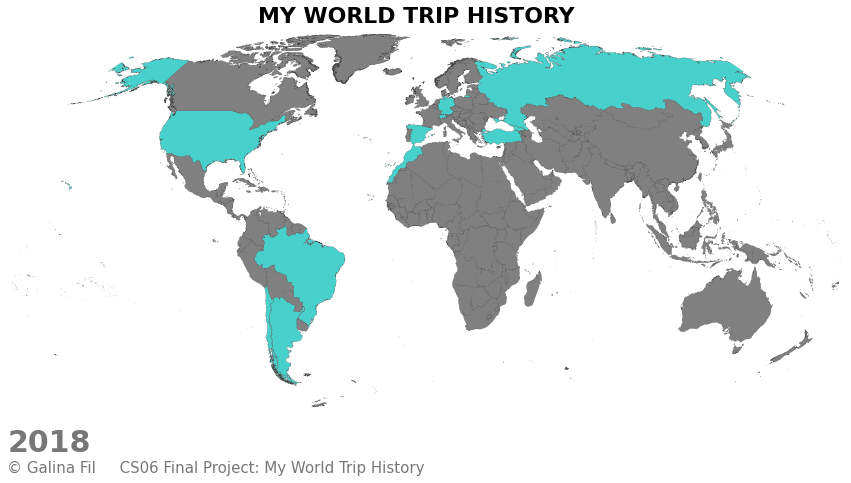

In [ ]:
#Create world map of visited countries in certain year
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, frame_on = False)
country_map = Basemap(projection='robin',lon_0=0)
country_map.drawmapboundary(color='w')
country_map.readshapefile('all_country', 'units', color='#444444', linewidth=.2)

#define the func that will draw travel history for particular year
def travel_history(current_year):
  country_subset = country_data[country_data.Year == current_year]
  
  #add mention of the year on the plot
  ax.text(50,5,2019, size = 30, weight = 1000, color = 'w')
  ax.text(50,5,current_year-1, size = 30, weight = 1000, color = 'w', backgroundcolor = 'w')

  for info, shape in zip(country_map.units_info, country_map.units):
    iso3 = info['ADM0_A3']
    if iso3 not in country_subset.index:
        color = 'grey'
    else:
        color = 'mediumturquoise'
    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)
  
  #cover up antartica
  ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2) 

  #add title and caption on the plot
  ax.text(0.3, 1.01, 'MY WORLD TRIP HISTORY', size=22, fontweight='bold', weight = 800,transform=ax.transAxes)
  ax.text(x=0, y=-0.05, s="""© Galina Fil     CS06 Final Project: My World Trip History""", fontsize=15, color='#777777', transform=ax.transAxes)
  ax.text(50,5,current_year, size = 30, weight = 800, color = '#777777')

travel_history(2018)



---

Ok, and what if they keep asking? Let's create a little animation highlighting the countries on the map that you were visiting year after year. Kids like cartoons, huh?

---



In [ ]:
#animation
animator1 = animation.FuncAnimation(fig, travel_history, frames = range(2007,2021), interval = 500, repeat = True)
HTML(animator1.to_jshtml())

In [ ]:
#save animation
animator1.save('world_trip_history.mp4')
files.download('world_trip_history.mp4')

## Frequently Visited Countries


It's cool to see colored maps, but what's about statistics? Number of countries every year, frequently visited regions of the world etc

First of all let's have a look on the countries that have been visited the most.

---

In [ ]:
#creating data for the plot

#count entries of each country in country_data and create a dict: country:number_of_visits
freq_visit_country = {}
for country in country_data.Country:
  freq_visit_country[country] = freq_visit_country.get(country, 0) + 1

#create a df out of the dict
fvc_data = pd.DataFrame.from_dict(freq_visit_country, orient = 'index')
fvc_data = fvc_data.reset_index()
fvc_data.columns = ['Country','Frequency']

#get region from country_data to dict
region_dict = {}
for i in range(len(country_data)):
  region_dict[country_data.Country[i]] = country_data.Region[i]

#put region info to region_List to assign it later to fvc['region']
region_list = []
for country in fvc_data.Country:
  region_list.append(region_dict[country])

#create a new col for fvs_data
fvc_data['Region'] = region_list

#sort data by freq and then by region
fvc_data = fvc_data.sort_values(by=['Frequency','Region'] )

#add color to the bars, according to region
colors = dict(zip(
    fvc_data.Region.unique(),
    ['tab:grey', 'tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
))

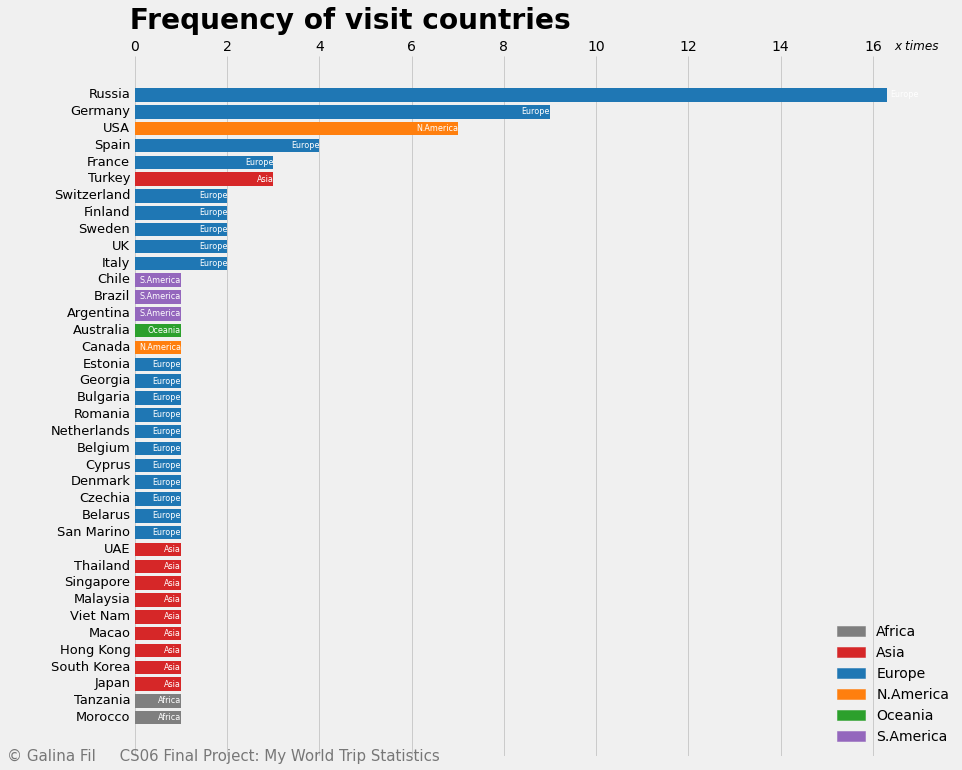

In [ ]:
#frequently visited cuntries bars

with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xlim(0,16.3)
    ax.barh(fvc_data['Country'], fvc_data['Frequency'], color = [colors[region_dict[x]] for x in fvc_data.Country])
    ax.set_facecolor('white')

    for i, (country, freq) in enumerate(zip(fvc_data['Country'], fvc_data['Frequency'])):
      ax.text(-0.1, i-0.15, country, size = 13, ha='right') #horizontalalignment (left, center, right)
      ax.text(freq, i-0.1, region_dict[country], size = 8, ha='right', color='white')
    
    #transform=ax.transAxes - transform axes dimensions: left-bottom(0,0), right-up(1,1)
    ## when animated text is at the same position
    ax.text(1.01,1.01, 'x times', transform=ax.transAxes, size = 12, style = 'italic' )
    ax.text(-0.02,1.04, ' Frequency of visit countries', fontweight = 'bold', weight = 800, transform=ax.transAxes, size = 28)
    ax.text(x=-0.17, y=-0.005, s="""© Galina Fil     CS06 Final Project: My World Trip Statistics""", fontsize=15, color='#777777', transform=ax.transAxes)

    #legend
    legend_list = []
    for region in fvc_data.Region.unique():
      patch = mpatches.Patch(color=colors[region], label=region)
      legend_list.append(patch)
    plt.legend(handles=legend_list, frameon = False, bbox_to_anchor=(1.1, 0), loc='lower right')
    
    #The formatter operates on a single tick value and returns a string to the axis by using str format method
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')

    #remove y ticks
    ax.set_yticks([])

    #add empty margin: 0.15 on x-axis, 0.03 on y-axis (for case when plot is beyond the fig)
    #ax.margins(0, 0.03)

    #add vertical lines to the plot
    ax.grid(which = 'major', axis = 'x', linestyle = '-')

    #Set whether axis ticks and gridlines are above or below most artists
    ax.set_axisbelow(True)

    #remove frame from the plot
    plt.box(False)


## Region Pie



Now let's have a look on the most visited regions. I know, I know everybody hates Pie charts :)

---

In [ ]:
#creating data for the plot

#count entries of each region in country_data and create a dict: region:number_of_visits
freq_visit_region = {}
for region in country_data.Region:
  freq_visit_region[region] = freq_visit_region.get(region, 0) + 1

fvr_data = pd.DataFrame.from_dict(freq_visit_region, orient = 'index')
fvr_data.reset_index(inplace = True)
fvr_data.columns = ['Region', 'Frequency']

percentage_list = []
for i in range(len(fvr_data)):
  percentage_list.append(fvr_data.Frequency[i]/sum(fvr_data.Frequency)*100)
fvr_data['Percentage'] = percentage_list


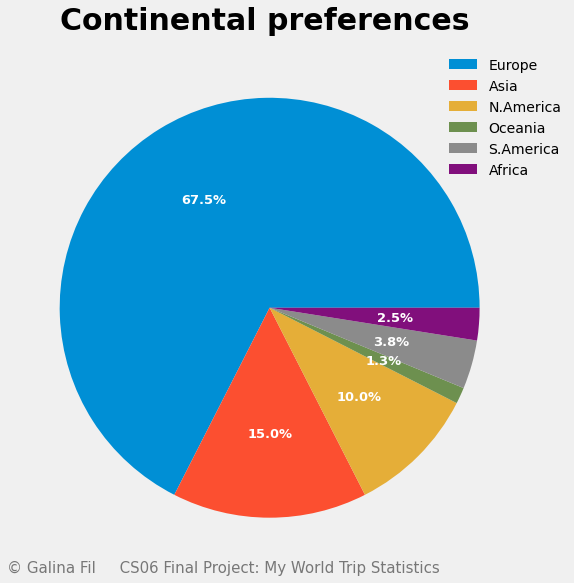

In [ ]:
#region pie

with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(9, 9))

    #convert pct to str
    def func(pct):
      return "{:.1f}%".format(pct)
    
    pie, texts, autotexts = ax.pie(fvr_data.Percentage, autopct=lambda pct: func(pct), textprops=dict(color="w"))
    
    #legend
    region = fvr_data.Region.values
    ax.legend(pie, region, bbox_to_anchor=(1.08, 1), frameon = False, loc='upper right')
    ax.text(0.1,1.03, 'Continental preferences', fontweight='bold', weight = 800, transform=ax.transAxes, size = 30)
    ax.text(x=0, y=-0.005, s="""© Galina Fil     CS06 Final Project: My World Trip Statistics""", fontsize=15, color='#777777', transform=ax.transAxes)

    plt.setp(autotexts, size=13, weight="bold")

## New countries per year


And by the end let's count how many countries have beed added to the collection each year.

---



In [ ]:
#creating data for the plot

#dict 'distinctive country': year
country_dict = {}
for i in range(len(country_data)):
  if not country_dict.get(country_data.Country[i], 0):
    country_dict[country_data.Country[i]] = country_data.Year[i]
  else: pass

#df out of country_dict
cy_data = pd.DataFrame.from_dict(country_dict, orient = 'index')
cy_data.reset_index(inplace = True)
cy_data.columns = ['Country', 'Year']

#dict 'year': #countries
year_dict = {}
for year in cy_data.Year:
  year_dict[year] = len(cy_data[cy_data.Year == year])
#complete empty years with 0
for i in range(2007, 2020):
 if i not in country_dict.values():
   year_dict[i] = 0

#df out of year_dict
country_per_year_data = pd.DataFrame.from_dict(year_dict, orient = 'index')
country_per_year_data.reset_index(inplace = True)
country_per_year_data.columns = ['Year', 'Quantity']
country_per_year_data = country_per_year_data.sort_values(by='Year')

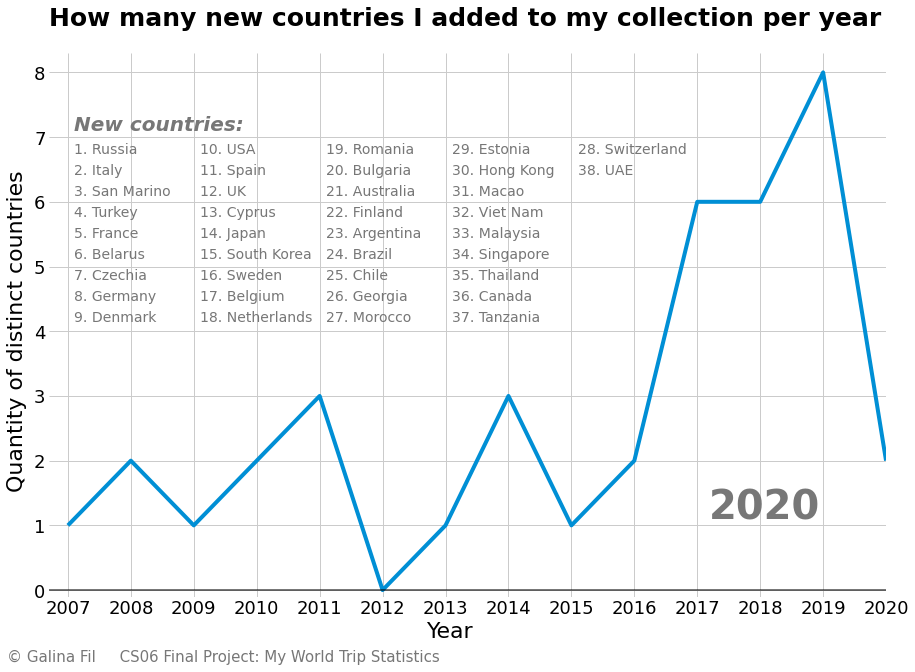

In [ ]:
# New countries per year plot

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, frame_on = False)

def country_per_year(current_year):
  yearly_subset = country_per_year_data[country_per_year_data.Year <= current_year]
  with plt.style.context('fivethirtyeight'):
    ax.clear()
    ax.plot(yearly_subset['Year'], yearly_subset['Quantity'])

    ax.set_xlim(2006.7, 2019.3)
    ax.set_xticks(country_per_year_data.Year.values)
    ax.set_ylim(-0.1, 8.3)
    ax.axhline(y=0, color='black',alpha=0.7,linewidth=1.5)
    ax.tick_params(axis='both', which='major', labelsize=18,color ='#777777') #customize axes ticks
    ax.set_axisbelow(True)
    
    ax.text(0.45,-0.075, 'Year', transform=ax.transAxes, size = 22)
    ax.text(-0.05, 0.2, 'Quantity of distinct countries', rotation = '90', transform=ax.transAxes, size = 22)
    ax.text(2017.18, 1.1, current_year, size=40, fontweight='bold', color = '#777777', weight = 1000)
    ax.text(2007.1, 7.1, 'New countries:', size=20, style = 'italic', fontweight='bold', color = '#777777', weight = 1000)
    ax.text(0, 1.05, 'How many new countries I added to my collection per year', size=25, fontweight='bold', weight = 800,transform=ax.transAxes)
    ax.text(x=-0.05, y=-0.12, s="""© Galina Fil     CS06 Final Project: My World Trip Statistics""", fontsize=15, color='#777777', transform=ax.transAxes)

    country_subset = cy_data[cy_data.Year <= current_year]
    count = [0 ,0, 0, 0, 0]
    for i in range(len(country_subset)):
      if i < 9:
        ax.text(2007.1, 6.75+count[0], str(i+1) + '. ' + country_subset.Country[i], size=14, color = '#777777')
        count[0] = count[0] - 0.325
      elif i in range(9,18):
        ax.text(2009.1, 6.75+count[1], str(i+1) + '. ' + country_subset.Country[i], size=14, color = '#777777')
        count[1] = count[1] - 0.325
      elif i in range(18,27):
        ax.text(2011.1, 6.75+count[2], str(i+1) + '. ' +  country_subset.Country[i], size=14, color = '#777777')
        count[2] = count[2] - 0.325
      elif i in range(28,37):
        ax.text(2013.1, 6.75+count[3], str(i+1) + '. ' +  country_subset.Country[i], size=14, color = '#777777')
        count[3] = count[3] - 0.325
      else: 
        ax.text(2015.1, 6.75+count[4], str(i+1) + '. ' +  country_subset.Country[i], size=14, color = '#777777')
        count[4] = count[4] - 0.325

country_per_year(2020)



---


And jut for fun let's add some drive to this chart and make it alive.

---



In [ ]:
#animation
animator = animation.FuncAnimation(fig, country_per_year, frames = range(2007,2021), interval = 500, repeat = True)
HTML(animator.to_jshtml())

In [ ]:
animator.save('new_countries_per_year.mp4')
files.download('new_countries_per_year.mp4')



---



# Flights



Now let's jump into the clouds and have a look on all those flights that have been made to visit all this wonderful places. For this purpose we will use **matplotlib** & **Basemap** again.

---



In [ ]:
#load data
flight_data = pd.read_csv('https://raw.githubusercontent.com/pe44enka/main/master/data/flights.csv')
flight_data.tail()

DEPART_DATE FLIGHT_NUMBER  ...          CITY2        COUNTRY
167   17-Aug-20         F9665  ...  San Francisco  United States
168    4-Sep-20        AS1477  ...        Seattle  United States
169    4-Sep-20         AS101  ...      Anchorage  United States
170   13-Sep-20          AS98  ...        Seattle  United States
171   13-Sep-20        AS1328  ...  San Francisco  United States

[5 rows x 21 columns]

## My Flights Map

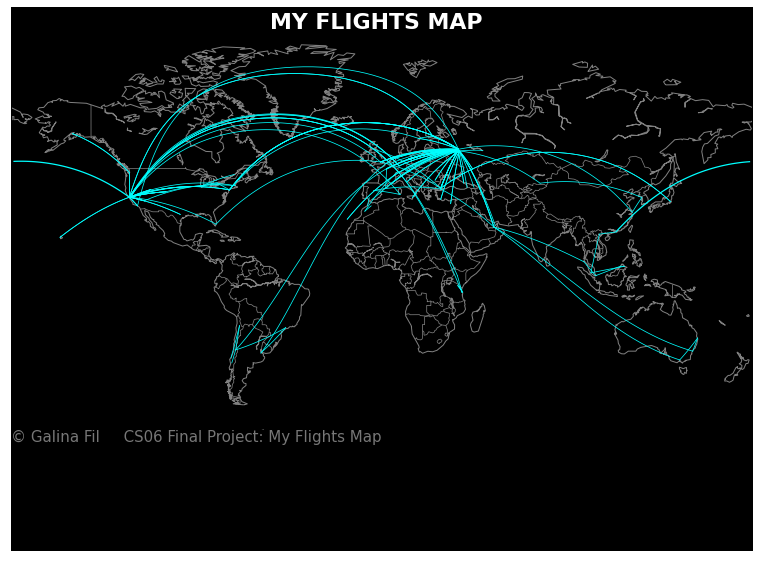

In [ ]:
#flight map

fig2 = plt.figure(figsize=(15,10))
ax = fig2.add_subplot(111, frame_on = False)
flight_map = Basemap(projection='mill',lon_0=0)
flight_map.drawcoastlines(color = 'grey', linewidth=1.0)
flight_map.drawcountries(color = 'grey', linewidth=0.75)
flight_map.fillcontinents(color='black',lake_color='black')
flight_map.drawmapboundary(fill_color='black')

for i in flight_data.index:
  line, = flight_map.drawgreatcircle(flight_data['DEPART_LON'][i], flight_data['DEPART_LAT'][i],
                                  flight_data['ARR_LON'][i], flight_data['ARR_LAT'][i], 
                                  linewidth=1.25, color='aqua')
  if i != 125:
    line.remove()
    mx,my = line.get_data()
    flight_map.plot(mx,my, color="aqua", linewidth = 0.75)

ax.axhspan(0, 1000 * 6500, facecolor='black', edgecolor='black', zorder=2) #cover up Antarctica

ax.text(0.35, 0.96, 'MY FLIGHTS MAP', size=22, fontweight='bold', weight = 800,transform=ax.transAxes, color = 'white')
ax.text(x=0, y=0.2, s="""© Galina Fil     CS06 Final Project: My Flights Map""", fontsize=15, color='#777777', transform=ax.transAxes)
plt.show()



---



# World City Map



We've already seen all flights, all countries and even all states inside of US that have been visited. But what's about cities around the globe? Let's create world map of visited cites by using **folium**.

---



In [ ]:
# create dataset with visited cities coordinates
city_data = pd.DataFrame(columns = ['City', 'Lat', 'Lon'])
cities = ['Ufa', 'Kostroma', 'Minsk', 'Brest', 'Belgorod', 'Vladimir', 'Suzdal', 'Naberegnye Chelny', 'Innopolis','Sviyazhsk',
          'San Marino', 'Florence', 'Venice', 'Sienna', 'Rome', 'Pisa', 'St. Peterburg', 'Svetlogorsk', 'Sevastopol', 
          'Simferopol', 'Evpatoria', 'Yalta', 'Feodosia', 'Novomoskovsk', 'Marmaris', 'Pamukkale', 'Krumlov', 'Dresden',
          'Rostock', 'Greiswald', 'Schwerin', 'Hamburg', 'Philadephia', 'Washington', 'Carmel-by-the-City', 'Monterey',
          'Santa Cruz', 'Oxford', 'Salisbury', 'Ayia Napa', 'Kyoto', 'Nara', 'Nikko', 'Kamakura', 'Fujinomiya', 'Bloise',
          'Versailles', 'Figueres', 'Palermo', 'Taormina', 'Gyeongju-si', 'Brugge', 'Cardiff', 'Sighisoara', 'Brasov', 
          'Constanta', 'Golden Sands', 'Brisbane', 'Belmont', 'Stanford', 'Vidnoye', 'Bakersfield', 'Fresno', 'Sacramento',
          'Redding', 'Santa Rosa', 'Pukon', 'Nikola-Lenivets', 'Granada', 'Fes', 'Ouarzazate', 'Basel', 'Tallin', 
          'Cambridge', 'Salem', 'Rockport', 'Gunnison', 'Moab', 'Flagstaff', 'South Lake Tahoe', 'Kings Beach', 
          'San Antonio', 'Dallas', 'Montreal', 'Arusha']
lats = [54.7388, 57.7775, 53.9006, 52.0997, 50.5997, 56.1446,56.4192, 55.7185, 55.7517,55.7711,
        43.9424, 43.7696, 45.4408,43.3188, 41.9028, 43.7228, 59.9343, 54.9395, 44.6166,
        44.9521, 45.1905, 44.4909, 45.0319, 54.0109, 36.8549, 37.9137, 48.8127,51.0504,
        54.0924,54.0865, 53.6355, 53.5511, 39.9526, 38.895,36.5552, 36.6002, 
        36.9741, 51.7520, 51.0688, 34.9923, 35.0116, 34.6851, 36.7199, 35.3192,35.2221,47.5861,
        48.8014, 42.2655, 38.1157, 37.8516, 35.8562, 51.2093, 51.4816, 46.2197, 45.6580,
        44.1598, 43.2856, 27.4698, 37.5202, 37.4275, 55.5471, 35.3733, 36.7378, 38.5816,
        40.5865, 38.4404, 39.2723, 54.7519, 37.1773, 34.0181, 30.9335, 47.5596, 59.4370,
        42.3736, 42.5195, 42.6557, 38.5458, 38.5733, 35.1983, 38.9399, 39.2377,
        29.4241, 32.7767, 45.5017, -3.3869]
lons = [55.9721, 40.9699, 27.5590, 23.7637, 36.5983, 40.4179, 40.4536, 52.3721, 48.7473,48.6584,
        12.4578, 11.2558, 12.3155, 11.3308, 12.4964, 10.4017, 30.3351, 20.1585, 33.5254,
        34.1024, 33.3669,34.1533,35.3824, 38.2963, 28.2709, 29.1187, 14.3175,13.7373,
        12.0991, 13.3923, 11.4012, 9.9937, -75.1652, -77.0366, -121.9233, -121.8947,
        -122.0308, -1.2577, -1.7945, 34.014, 135.7681, 135.8048, 139.6982, 139.5467,138.6216, 1.3359,
        2.1301, 2.9581, 13.3615, 15.2853,129.2247, 3.2247, -3.1791, 24.7964, 25.6012,
        28.6348, 28.0406, 153.0251, -122.2758, -122.1697, 37.6986, -119.0187, -119.7871, -121.4944,
        -122.3917, -122.7141, -71.9776, 35.5998, -3.5986, -5.0078, -6.9370, 7.5886, 24.7536,
        -71.1097, -70.8967, -70.6204, -106.9253, -109.5498, -111.6513, -119.9772, -120.0266,
        -98.4936, -96.7970, -73.5673, 36.6830]
city_data['City'] = cities
city_data['Lat'] = lats
city_data['Lon'] = lons

In [ ]:
#add cities on the folium map
#scroll to navigate
city_map = folium.Map([51.4706,-0.461941], zoom_start = 2)

#add cities from flight dataset
for i in range(len(flight_data)): 
  folium.Marker([flight_data.iloc[i]['DEPART_LAT'], flight_data.iloc[i]['DEPART_LON']], popup = flight_data.iloc[i]['DEPART_CITY']).add_to(city_map)
  folium.Marker([flight_data.iloc[i]['ARR_LAT'], flight_data.iloc[i]['ARR_LON']], popup = flight_data.iloc[i]['ARR_CITY']).add_to(city_map)

#add cities from city_data dataset
for i in range(len(city_data)):  
  folium.Marker([city_data.iloc[i]['Lat'], city_data.iloc[i]['Lon']], popup = city_data.iloc[i]['City']).add_to(city_map)
city_map.save('city_map.html')
city_map



---



# Statistics


And finally to summarize all that, let's make last quite easy table with statistic about all made trips.

---



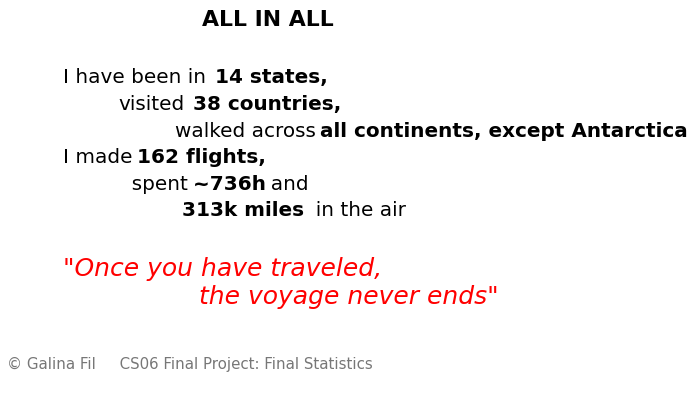

In [ ]:
#get num of hours out of duration of flight
hour = minute = 0
for time in pd.DatetimeIndex(flight_data.FLIGHT_DURATION).time:
  hour += time.hour
  minute += time.minute
hours = hour + round(minute / 60)

fig3 = plt.figure(figsize=(10,7))
ax = fig3.add_subplot(111,frame_on = False)

def trip_stat(mylist):
  ax.clear()
  ax.set_xticks([])
  ax.set_yticks([])

  ax.text(0.35, 0.95, 'ALL IN ALL', size=22, fontweight='bold', weight = 800)
  ax.text(0, 0.05, s="""© Galina Fil     CS06 Final Project: Final Statistics""", fontsize=15, color='#777777', transform=ax.transAxes)

  ax.text(0.1, 0.8, 'I have been in',size = 20 )
  ax.text(0.36, 0.8, ' {} states,'.format(len(state_data)), size = 20, fontweight = 'bold')
  ax.text(0.2, 0.73, 'visited',size = 20 )
  ax.text(0.32, 0.73, ' {} countries,'.format(len(fvc_data)), size = 20, fontweight = 'bold')
  ax.text(0.3, 0.66, 'walked across',size = 20 )
  ax.text(0.56, 0.66, 'all continents, except Antarctica', size = 20, fontweight = 'bold')
  ax.text(0.1, 0.59, 'I made',size = 20 )
  ax.text(0.22, 0.59, ' {} flights,'.format(len(flight_data)), size = 20, fontweight = 'bold')
  ax.text(0.2, 0.52, '  spent',size = 20 )
  ax.text(0.32, 0.52, ' ~{}h'.format(str(hours)), size = 20, fontweight = 'bold')
  ax.text(0.45, 0.52, '  and',size = 20 )
  ax.text(0.3, 0.45, ' 313k miles', size = 20, fontweight = 'bold')
  ax.text(0.53, 0.45, '  in the air',size = 20 )

  ax.text (0.1, 0.22, '"Once you have traveled,\n                 the voyage never ends"', style = 'italic', fontsize = 25, color = 'r')

trip_stat((14, 40, 'all continents, except Antarctica', 155, 692, 294))

---

So that's all. Thank you for your attention and interest to my project! :)

---